In [276]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [513]:
class Value: 
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.grad = 0.0
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other): 
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        
        return out
        
    def __mul__(self, other): 
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
    
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
    
        return out

    def __rmul__(self, other): # fallback mul for 2*a -> a*2
        return self * other;    

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __radd__(self, other):
        return self + other
        
    def __rsub__(self, other):
        return -self + other

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n)+1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
            
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0 
        for node in reversed(topo):
            node._backward()
        

In [52]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

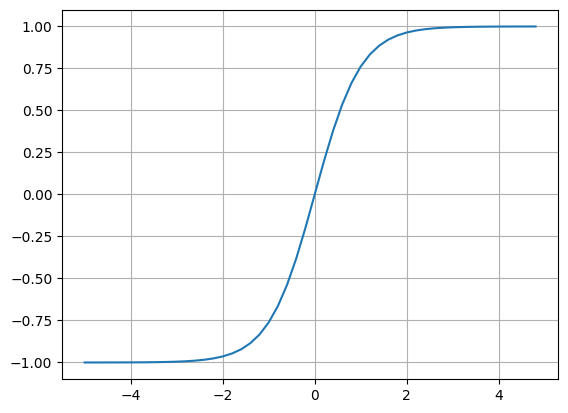

In [134]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [250]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

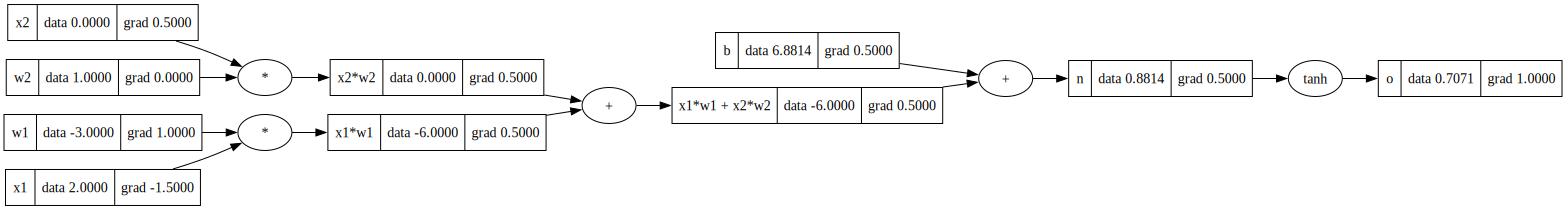

In [251]:
draw_dot(o)

In [275]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

In [520]:

class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    # process the weights, inputs, bias, inputs that to an activation function and gives output
    def __call__(self, x):
        # z = w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        # y = f(z)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    # returns a list of neurons with nin: inputs of out neuron nout: number of neurons
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    # recursively generate output from input layer and feed it forward to next layers 
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

        

In [628]:
n.parameters(), len(n.parameters())

([Value(data=-1.3945064573117125),
  Value(data=-0.7228755897287811),
  Value(data=0.17975361176504903),
  Value(data=-0.6671650935215687),
  Value(data=0.7472355039935201),
  Value(data=1.4733950381362666),
  Value(data=-2.4720720997698096),
  Value(data=0.3158481787753418),
  Value(data=1.8293587841291865),
  Value(data=-1.984373886473147),
  Value(data=1.4263881598628965),
  Value(data=-0.3669808064780386),
  Value(data=-1.8831214891254904),
  Value(data=-0.8116043239011579),
  Value(data=-0.18143911662641385),
  Value(data=-1.8215821662083231),
  Value(data=1.7735013687544265),
  Value(data=3.0161195722701146),
  Value(data=0.18959414899099156),
  Value(data=-1.1404583841364273),
  Value(data=-0.8711029374804696),
  Value(data=0.4566643457100508),
  Value(data=1.145252346682487),
  Value(data=-0.09991269126488103),
  Value(data=0.6811688929743992),
  Value(data=-1.9584477041779658),
  Value(data=0.40260263509170596),
  Value(data=2.5463621584097074),
  Value(data=0.0524121084340273

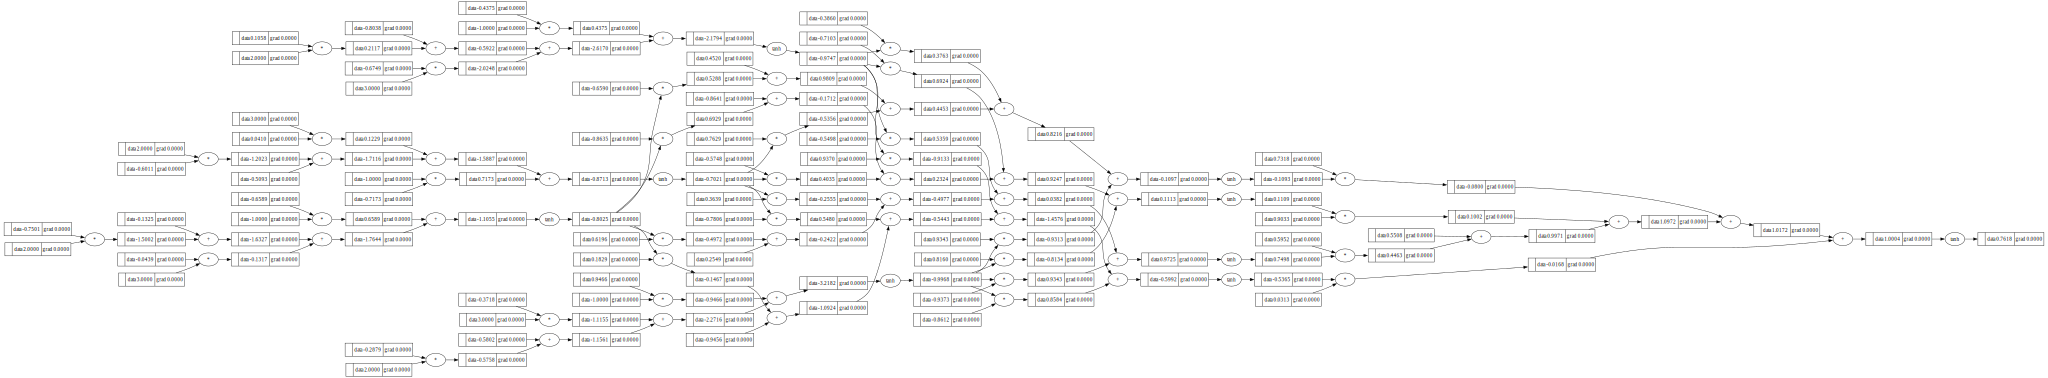

In [523]:
draw_dot(n(x))

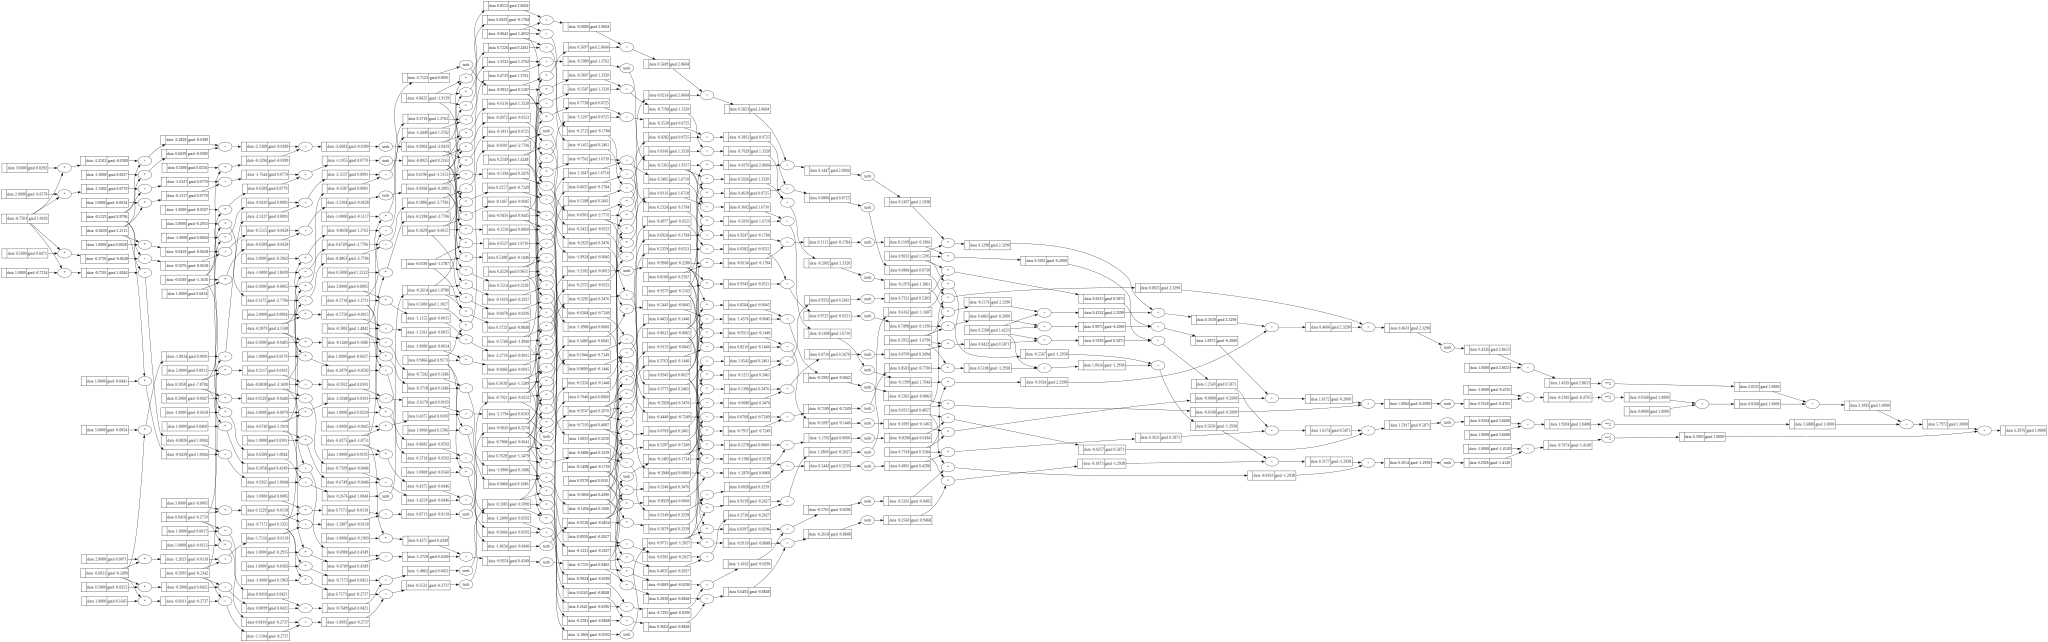

In [528]:
draw_dot(loss)

In [680]:
# x = [2.0, 3.0, -1.0]
# n = Layer(3, 3)
# n(x)

# x = [2.0, 3.0, -1.0]
# n = Neuron(2)
# n(x)

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.5707003640355306)

In [681]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [805]:
# single metric that calculates the performance of the neuralnet
# capture the collective measure of all the input and pred 
# prefer square over mod as mod is not differentiable at x=0, square is easier to differentiate
# which you have to do a lot of in optimization of model

## !!! Most common mistake is to not resetting the grad to 0 before .backward()
## we accumulate the grad so we need to reset it everytime

for k in range(20):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -(0.05 * p.grad)    

    print(k, loss.data)
    

0 0.00011470749029414109
1 0.00011468566952642809
2 0.00011466385690614311
3 0.0001146420524287544
4 0.00011462025608972466
5 0.00011459846788453064
6 0.00011457668780864887
7 0.00011455491585755492
8 0.00011453315202672999
9 0.00011451139631166486
10 0.00011448964870784876
11 0.0001144679092107687
12 0.00011444617781592505
13 0.00011442445451881447
14 0.00011440273931493931
15 0.00011438103219980794
16 0.0001143593331689265
17 0.00011433764221780888
18 0.00011431595934196578
19 0.00011429428453692617


In [806]:
ypred

[Value(data=0.99521976713522),
 Value(data=-0.9942245646236922),
 Value(data=-0.9949820574576032),
 Value(data=0.9942634281011479)]

In [822]:
n([10,3,-10])

Value(data=0.9956772000865208)